In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from ImageOperations import get_cropped_denoised, get_cropped, getImage, get_mask, get_ROI
from skimage.measure import points_in_poly
from skimage.morphology import extrema
import skimage as ski
import scipy.ndimage as ndi


In [53]:
class RGB:
    def __init__(self, shape = None, canvas = False):
        self.colors = {"r":[0],
                       "g":[1],
                       "b":[2],
                       "y":[0,1],
                       "m":[1,2],
                       "c":[0,2],
                       "w":[0,1,2]}
        self.shape = shape
        if self.shape != None:
            if canvas == True:
                self.img = np.ones([*self.shape,3]).astype("uint8")*255
            else: 
                self.img = np.zeros([*self.shape,3]).astype("uint8")
        pass
    
    def add_image(self, image, color):
        if self.shape == None:
            self.shape = image.shape
            self.img = np.zeros(tuple([*self.shape,3])).astype("uint8")
        elif self.shape != image.shape:
            raise Exception("Shapes don't comply!")
        temp_img = np.zeros_like(self.img)
        for c in self.colors[color]:
            temp_img[:,:,c] = ski.util.img_as_ubyte(ski.exposure.equalize_adapthist(image))
        self.img = np.max(
            np.stack([self.img, temp_img], axis = 3),
            axis = 3
        )
        return self
    
    def show(self):

        #rgb = ski.color.gray2rgb(self.img, channel_axis=2)
        plt.imshow(self.img)
        return self
    
    def save(self, filename):
        ski.io.imsave(filename, self.img)
        return self
    
    def add_boundary(self, coords, color, thickness = 1):
        coordmat = np.zeros(self.shape, dtype = bool)
        coordmat[coords.T.astype(int)[1],
                 coords.T.astype(int)[0]] = True
        coordmat = ndi.binary_dilation(coordmat, iterations = thickness).astype("uint8")*255
        temp_img = np.zeros_like(self.img)
        for c in self.colors[color]:
            temp_img[:,:,c] = coordmat
        self.img = np.max(
            np.stack([self.img, temp_img],axis = 3),
            axis = 3
        )
        return self
    
    def draw_x(self, coords, color, radius = 5):
        coordmat = np.zeros(self.shape, dtype = bool)
        for coord in coords:
            d_r, d_c = ski.draw.disk(center = coord, radius = radius, shape = self.shape)
            l1 = ski.draw.line(np.min(d_r), np.min(d_c), np.max(d_r), np.max(d_c))
            l2 = ski.draw.line(np.max(d_r), np.min(d_c), np.min(d_r), np.max(d_c))
            coordmat[l1] = True
            coordmat[l2] = True
        coordmat = ndi.binary_dilation(coordmat, iterations = 2).astype("uint8")*255
        temp_img = np.zeros_like(self.img)
        for c in self.colors[color]:
            temp_img[:,:,c] = coordmat
        self.img = np.max(
            np.stack([self.img, temp_img],axis = 3),
            axis = 3
        )
        return self
    
    def draw_c(self, coords, color, radius = 5):
        coordmat = np.zeros(self.shape, dtype = bool)
        for coord in coords:
            disk = ski.draw.disk(center = coord, radius = radius, shape = self.shape)
            coordmat[disk] = True
        coordmat = ndi.binary_dilation(coordmat, iterations = 1).astype("uint8")*255
        temp_img = np.zeros_like(self.img)
        for c in self.colors[color]:
            temp_img[:,:,c] = coordmat
        self.img = np.max(
            np.stack([self.img, temp_img],axis = 3),
            axis = 3
        )
        return self

In [54]:
df = pd.read_excel(r"E:\diploma_thesis\Data\3. Plasmid moves cargo into Lysosomes\Results.xlsx")
data = df.loc[df["Group2"]=="LAMP1"]

rmap = LinearSegmentedColormap.from_list(
        "Custom", 
        [(0, 0, 0), (1, 0, 0)], 
        N=255)

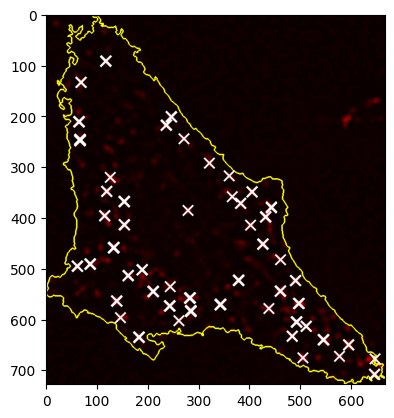

In [67]:
test_CID = 2
test_ROI = get_ROI(data,test_CID)
boundary = test_ROI.coordinates()-[[test_ROI.left,test_ROI.top]]
stack_img_lamp1 = getImage(data.loc[data["CID"]==test_CID,"denoised_path"].values[0],2).astype("uint16")
test_img_lamp1 = np.max(getImage(data.loc[data["CID"]==test_CID,"denoised_path"].values[0],2).astype("uint16"), axis =0)

maxima_lamp1 = np.stack(np.where(ski.morphology.h_maxima(stack_img_lamp1,20))).T
intracellular = ski.measure.points_in_poly(maxima_lamp1[:,1:3], np.flip(boundary))
RGB().add_image(test_img_lamp1,"r").add_boundary(boundary, "y").draw_x(maxima_lamp1[intracellular,1:3],"w", radius=10).show()

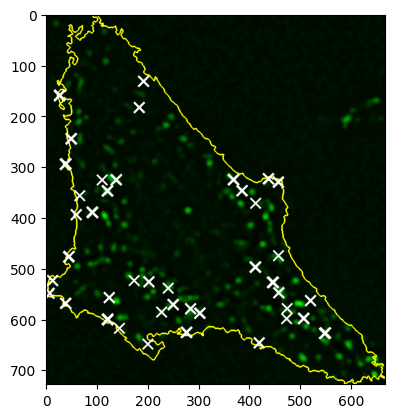

In [81]:
test_CID = 2
test_ROI = get_ROI(data,test_CID)
boundary = test_ROI.coordinates()-[[test_ROI.left,test_ROI.top]]
stack_img_lamp1 = getImage(data.loc[data["CID"]==test_CID,"denoised_path"].values[0],1).astype("uint16")
test_img_lamp1 = np.max(getImage(data.loc[data["CID"]==test_CID,"denoised_path"].values[0],2).astype("uint16"), axis =0)

maxima_lamp1 = np.stack(np.where(ski.morphology.h_maxima(stack_img_lamp1,20))).T
intracellular = ski.measure.points_in_poly(maxima_lamp1[:,1:3], np.flip(boundary))
# RGB().add_image(test_img_lamp1,"g").add_boundary(boundary, "y").show()
RGB().add_image(test_img_lamp1,"g").add_boundary(boundary, "y").draw_x(maxima_lamp1[intracellular,1:3],"w", radius=10).show()

In [82]:
import os
from tqdm import tqdm

def detect_points():
    return


def get_points(data = None,
               channel_name = None,
               channel_id = None,
               height = 10,
               dir = None):
    cols = ["z","y","x"]
    for CID in tqdm(data.loc[:,"CID"]):
        celldir = os.path.join(dir,str(CID))
        if not os.path.exists(celldir):
            os.makedirs(celldir)
        image = getImage(data.loc[data["CID"]==CID,"denoised_path"].values[0],channel_id).astype("uint16")
        ROI = get_ROI(data,CID)
        boundary = ROI.coordinates()-[[ROI.left,ROI.top]]
        maxima = np.stack(np.where(ski.morphology.h_maxima(image,height))).T
        intracellular = ski.measure.points_in_poly(maxima[:,1:3], np.flip(boundary))
        pdf = pd.DataFrame(data = {cols[i]: v for i,v in enumerate(maxima[intracellular,:].T)})
        pdf.to_csv(os.path.join(celldir,channel_name+".csv"),index=False)
    return

dir = r"E:\diploma_thesis\Data\3. Plasmid moves cargo into Lysosomes\Points\LAMP1"
get_points(data = data, channel_id = 1, dir = dir, channel_name="aSyn", height = 20)
get_points(data = data, channel_id = 2, dir = dir, channel_name="LAMP1", height = 20)

  0%|          | 0/95 [00:00<?, ?it/s]

100%|██████████| 95/95 [03:02<00:00,  1.92s/it]


In [83]:
from scipy.spatial import KDTree

def calculate_distance(X, Y):
    d,_ = KDTree(Y).query(X)
    return d

def get_d_for_cell(c_dir, ch1, ch2, plens):
    df1 = pd.read_csv(os.path.join(c_dir,ch1)+".csv")
    df2 = pd.read_csv(os.path.join(c_dir,ch2)+".csv")
    X = df1.iloc[:,:3].apply(lambda x: x*plens[x.name]).values

    Y = df2.iloc[:,:3].apply(lambda x: x*plens[x.name]).values
    d = calculate_distance(X,Y)
    return d

def calculate_NN(data, dir, channel1, channel2, plens):
    dist_df_list = []
    c = 0
    for CID in tqdm(data.loc[:,"CID"]):
        # if c > 0:
        #     continue
        # c += 1
        c_dir = os.path.join(dir,str(CID))
        d = get_d_for_cell(c_dir, channel1, channel2, plens)
        d_df = pd.DataFrame(data = {"d": d})
        d_df["CID"] = CID
        d_df["Group"] = data.loc[data["CID"]==CID,"Group1"].values[0]
        dist_df_list.append(d_df)
    NN_df = pd.concat(dist_df_list, axis = 0, ignore_index=True)
    return NN_df
    
plens = {"x": 0.07530842430163,
         "y": 0.07530842430163,
         "z": 0.2}

NN_df = calculate_NN(data,
                     dir,
                     "LAMP1",
                     "aSyn",
                     plens)

NN_df.head()
NN_df.to_csv(r"E:\diploma_thesis\Data\3. Plasmid moves cargo into Lysosomes\LAMP1_distances.csv", index=False)

100%|██████████| 95/95 [00:01<00:00, 89.14it/s] 


In [84]:
NN_df = pd.read_csv(r"E:\diploma_thesis\Data\3. Plasmid moves cargo into Lysosomes\LAMP1_distances.csv")
NN_df.head()

,d,CID,Group
0,1.147064,2,FY
1,1.216645,2,FY
2,1.246576,2,FY
3,1.588633,2,FY
4,1.186085,2,FY


In [85]:
import seaborn as sns
from functools import partial
# from analyze_data import pv_to_star

def analyze(x, ctrl=None, n_iter = 1000):
    S = {}
    S["mean"] = np.mean(x)
    permut = np.mean(np.random.choice(x.values.T[0], (len(x),n_iter)), axis = 0)
    S["ci_lo"] = np.quantile(permut, 0.025)
    S["ci_hi"] = np.quantile(permut, 0.975)
    permut_ctrl = np.mean(np.random.choice(ctrl, (len(ctrl),n_iter)),axis = 0)
    S["p"] = np.mean(permut-permut_ctrl < 0)
    
    return pd.Series(S)

summary_df = NN_df.groupby(["Group","CID"])["d"].apply(lambda x: np.mean(x < 0.25)).reset_index().sort_values("Group", axis=0, ascending=False)
summary_df.head()

,Group,CID,d
89,X,288,0.000000
77,X,261,0.000000
65,X,217,0.000000
66,X,222,0.000000
67,X,225,0.009901


In [86]:
ctrl = summary_df.loc[summary_df["Group"]=="X","d"].values
summary = summary_df.groupby("Group")[["d"]].apply(partial(analyze, ctrl = ctrl))
# summary["star"] = pv_to_star(summary["p"])
summary.head()

,mean,ci_lo,ci_hi,p
Group,,,,
FY,0.017257,0.006443,0.032425,0.844
TP,0.028779,0.010077,0.055505,0.626
X,0.035936,0.009161,0.078483,0.498


<Axes: xlabel='Group', ylabel='d'>

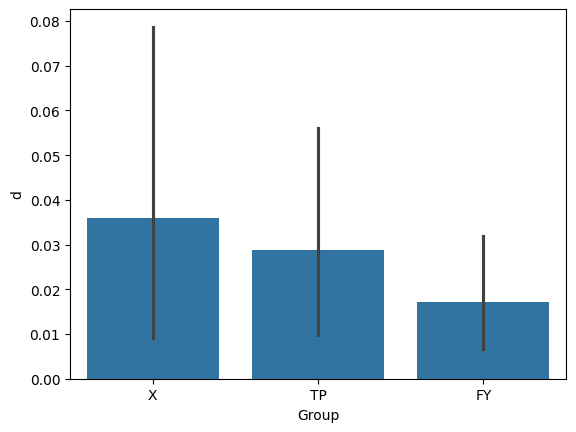

In [87]:
sns.barplot(summary_df, x = "Group", y="d")

In [88]:
from scipy.spatial import distance_matrix
from scipy.spatial import KDTree
import math
#from roifile import ImagejRoi

#from numpy.random import randint

def ripley(X,Y,boundary,R,maxD=10,area=None):

    if area == None:
        area = getArea(boundary)
    xtree = KDTree(X)
    ytree = KDTree(Y)
    btree = KDTree(boundary)
	#calculate distance between every point in X and Y
    D = distance_matrix(X, Y).T
   	#calculate shortest distance between X and boundary
    E = btree.query(X)[0]
   	#calculate boundary correction for every pair X and Y
    C = correct_boundary(D,E)
    K = []
   	# loop through all radii...
    for r in R:
   	#...and calculate k
        K.append(k_function(D,C,r,area))
   	#calculate L-function
    L = l_function(np.array(K))
   	#calculate AUC
    AUC = np.sum(L)
   	#correct AUC for assumed Poisson process
    AUC_D = np.sum(L-R)
    return L


def correct_boundary(D,E):

	minD = np.minimum(D+0.0001,E)/(D+0.0001)
	C = 1/(1-(np.arccos(minD))/math.pi)
	return C

def k_function(D,C,r,area):
    I = D<r
	#calculate K
    K = np.sum(C,where=I)*area/D.size
    return K

def l_function(K):
	L = np.sqrt(K/np.pi)
	return L

def getArea(boundary):
    x = boundary.T[1]
    y = boundary.T[2]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def get_r_for_cell(R, c_dir, ch1, ch2, plens, boundary):
    df1 = pd.read_csv(os.path.join(c_dir,ch1)+".csv")
    df2 = pd.read_csv(os.path.join(c_dir,ch2)+".csv")
    X = df1.iloc[:,:3].apply(lambda x: x*plens[x.name]).values
    Y = df2.iloc[:,:3].apply(lambda x: x*plens[x.name]).values
    d = ripley(X,Y, boundary, R)
    return d

def calculate_ripley(data, R, dir, channel1, channel2, plens, stack = 11):
    dist_df_list = []
    c = 0
    df = pd.DataFrame(columns=R)
    for CID in tqdm(data.loc[:,"CID"]):
        # if c > 0:
        #     continue
        # c += 1
        c_dir = os.path.join(dir,str(CID))
        ROI = get_ROI(data,CID)
        boundary2d = ROI.coordinates()-[[ROI.left,ROI.top]]
        boundary3d = np.concatenate([np.c_[np.ones((boundary2d.shape[0],1))*z, boundary2d] for z in range(stack)])

        L = get_r_for_cell(R, c_dir, channel1, channel2, plens, boundary3d)
        df.loc[CID,R] = L
        df.loc[CID,"Group"] = data.loc[data["CID"]==CID,"Group1"].values[0]
    melt_df = df.iloc[:,:-1].melt(ignore_index = False).join(df.iloc[:,-1]).reset_index()
    return melt_df
    
plens = {"x": 0.07530842430163,
         "y": 0.07530842430163,
         "z": 0.2}

R = np.arange(0.1,1.2, 0.1)

ripley_df = calculate_ripley(data,
                         R,
                     dir,
                     "LAMP1",
                     "aSyn",
                     plens)

ripley_df.head()
# NN_df.to_csv(r"E:\diploma_thesis\Data\3. Plasmid moves cargo into Lysosomes\LAMP1_ripley.csv", index=False)

 39%|███▉      | 37/95 [00:01<00:01, 34.47it/s]C:\Users\Raphael\AppData\Local\Temp\ipykernel_1880\206035526.py:44: RuntimeWarning: invalid value encountered in scalar divide
  K = np.sum(C,where=I)*area/D.size
C:\Users\Raphael\AppData\Local\Temp\ipykernel_1880\206035526.py:44: RuntimeWarning: invalid value encountered in scalar divide
  K = np.sum(C,where=I)*area/D.size
 48%|████▊     | 46/95 [00:01<00:01, 37.65it/s]C:\Users\Raphael\AppData\Local\Temp\ipykernel_1880\206035526.py:44: RuntimeWarning: invalid value encountered in scalar divide
  K = np.sum(C,where=I)*area/D.size
 54%|█████▎    | 51/95 [00:01<00:01, 39.47it/s]C:\Users\Raphael\AppData\Local\Temp\ipykernel_1880\206035526.py:44: RuntimeWarning: invalid value encountered in scalar divide
  K = np.sum(C,where=I)*area/D.size
 59%|█████▉    | 56/95 [00:01<00:00, 41.19it/s]C:\Users\Raphael\AppData\Local\Temp\ipykernel_1880\206035526.py:44: RuntimeWarning: invalid value encountered in scalar divide
  K = np.sum(C,where=I)*area/D.si

,index,variable,value,Group
0,2,0.1,6.195992,FY
1,2,0.2,16.393053,FY
2,2,0.3,17.524911,FY
3,2,0.4,17.524911,FY
4,2,0.5,21.463545,FY


<Axes: xlabel='variable', ylabel='value'>

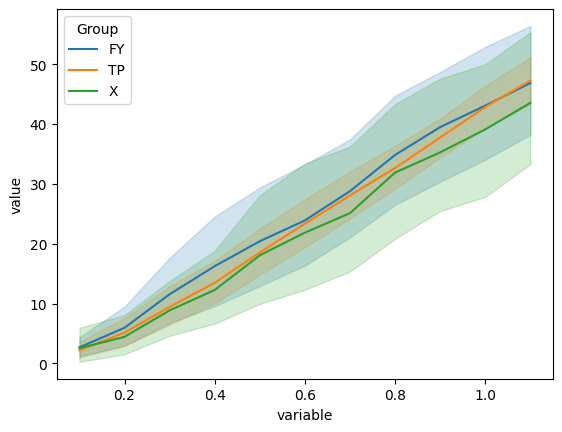

In [78]:
sns.lineplot(ripley_df, x = "variable", y = "value", hue = "Group")